### In this tutorial, we demonstrate how to apply ALLOCATE to temporal single-cell omics data (mouse pancreatic development) and spatiotemporal omics data (mouse brain ageing) for cell alignment.

#### Mapping cells across time points using single-cell gene expression.

In [1]:
%load_ext autoreload 
%autoreload 2

In [1]:
### First, we import the functions required to run the tutorial.
import scanpy as sc
import numpy as np
from sklearn.model_selection import train_test_split

from src.ALLOCATE import scALLOCATE
from src.ALLOCATE import stALLOCATE

from src.ALLOCATE import plot_ALLOCATE_a_distribution
from src.ALLOCATE import plot_ALLOCATE_a_umap
from src.ALLOCATE import plot_ALLOCATE_a_violin

from src.ALLOCATE import get_mapping
from src.ALLOCATE import compute_temporal_growth
from src.ALLOCATE import spearman_scatter_plot

from src.ALLOCATE import aggregate_pi_by_celltype
from src.ALLOCATE import plot_ALLOCATE_transfer_heatmap
from src.ALLOCATE import pi_process
from src.ALLOCATE import compute_mapping_accuracy

### This is the ALLOCATE tutorial for single-cell data.

We next load the mouse pancreas development dataset, which can be downloaded from moscot (https://moscot.readthedocs.io/en/latest/notebooks/tutorials/200_temporal_problem.html).

adata = mt.datasets.pancreas_multiome(rna_only=True, force_download=False)

In this dataset, embryonic pancreas tissues were profiled at embryonic days (E14.5, E15.5, and E16.5) using the 10x Genomics Multiome platform.

In [8]:
adata = sc.read_h5ad('pancreas_scrna.h5ad')

We visualize the dataset, coloring cells by cell type.

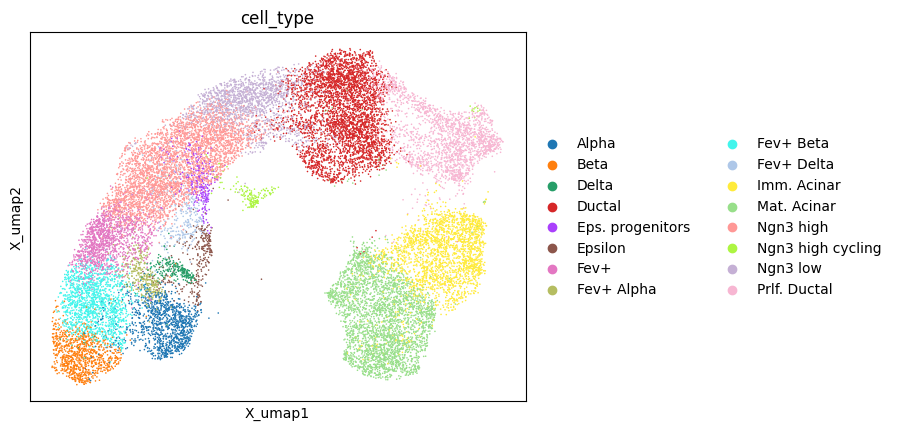

In [24]:
sc.pl.embedding(adata, basis="X_umap", color="cell_type")

### Compute the cost matrix and solve the problem.
As an illustrative example, we map cells at E14.5 to cells at E15.5. The cost matrix in the optimal transport problem is computed based on the Euclidean distance in the latent space defined by obsm['X_pca'].

In [9]:
#####This step will take approximately five minutes.
####The main returned value (a) represents the cell growth potential and (pi) represents the cell transition matrix.

# Run scALLOCATE
a, pi, stats, a_history, pi_history = scALLOCATE(adata, 
       early_tp="E14.5",
       late_tp="E15.5",
       time_key="stage", 
       rep="X_pca",
       epsilon=0.1,
       lambda_val=0.5,
       max_iters=10)


外层迭代 1/10
外层迭代 2/10
外层迭代 3/10
外层迭代 4/10
外层迭代 5/10
外层迭代 6/10
外层迭代 7/10
外层迭代 8/10
外层迭代 9/10
外层迭代 10/10


<Axes: title={'center': 'Marginal Distribution'}, xlabel='log10(a)', ylabel='Cell count'>

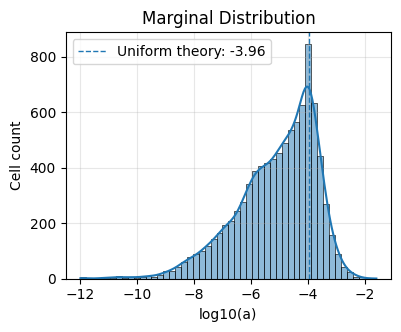

In [12]:
### ALLOCATE calculates the left marginal, and we visualize its distribution.
plot_ALLOCATE_a_distribution(
    a,
    title="Marginal Distribution",
    savepath=None,
)

In [14]:
E145 = adata[adata.obs["stage"]=='E14.5',:]
E155 = adata[adata.obs["stage"]=='E15.5',:]

/tmp/ipykernel_1211595/1557365967.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  E145.obs["ot_a"] = a
/lustre/home/acct-clswt/clswt-jiaxinchen/data/OT_manuscript_prepare/my_allocate/src/ALLOCATE/plotting.py:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs[group_mean_key] = adata.obs.groupby(group_key)[a_key].transform("mean")


<Axes: title={'center': 'UMAP colored by mean OT a (cell_type)'}, xlabel='UMAP1', ylabel='UMAP2'>

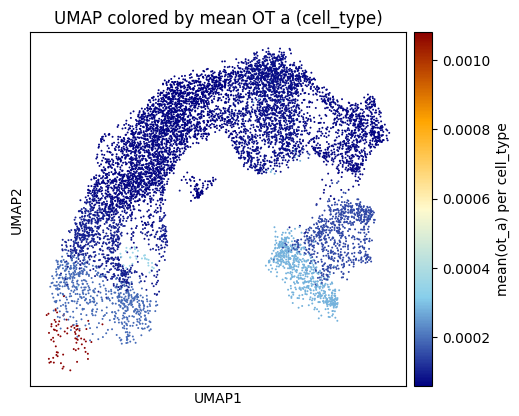

In [15]:
E145.obs["ot_a"] = a
### ALLOCATE calculates the left marginal, and we visualize its in UMAP space.
plot_ALLOCATE_a_umap(
    E145,
    a_key="ot_a",
    group_key="cell_type",
    title="UMAP colored by mean OT a (cell_type)",
    savepath=None,
)

/lustre/home/acct-clswt/clswt-jiaxinchen/data/OT_manuscript_prepare/my_allocate/src/ALLOCATE/plotting.py:373: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = adata.obs.groupby(group_key)[a_key].mean().sort_values(ascending=not descending).index.tolist()


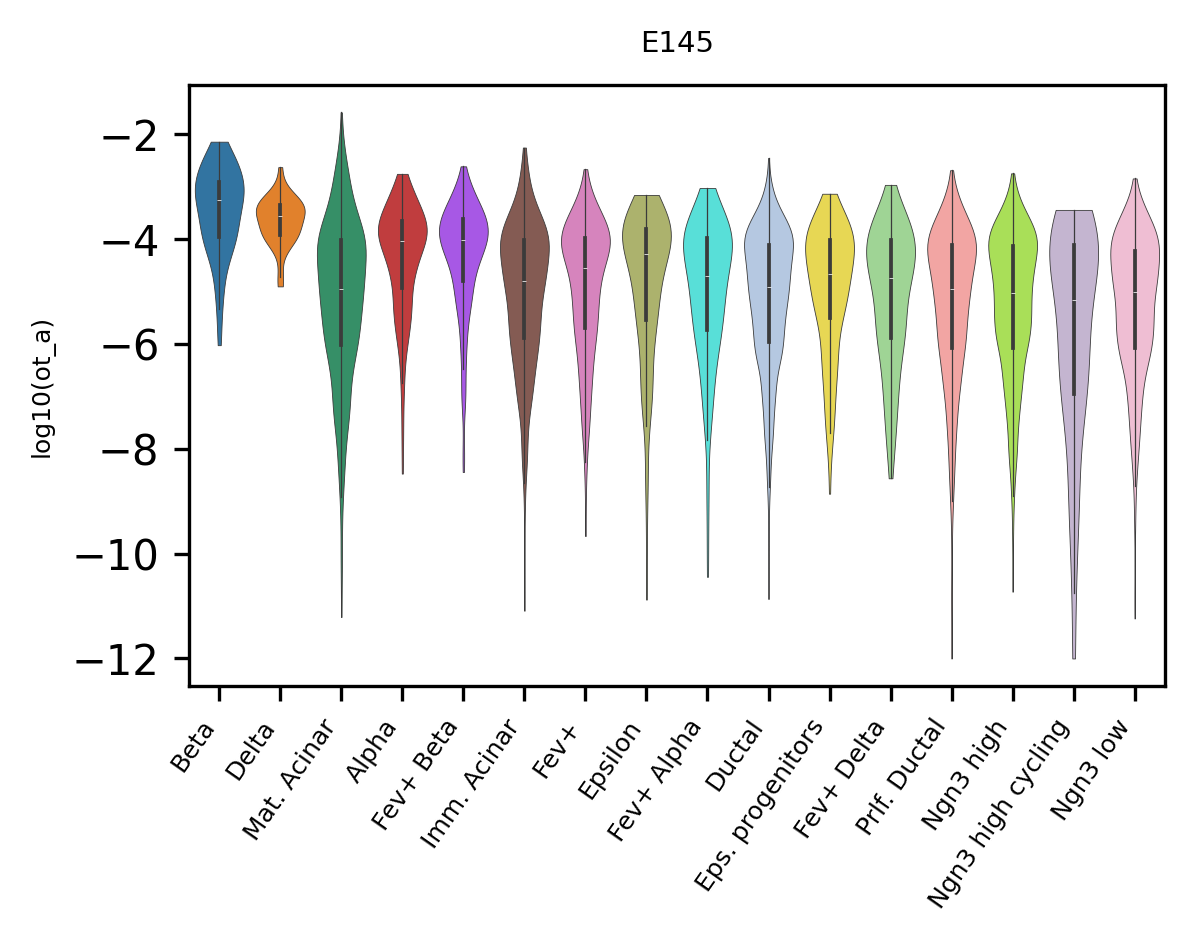

<Axes: title={'center': 'E145'}, ylabel='log10(ot_a)'>

In [16]:
#### We display the growth potential at E14.5 for individual cells and compare it across cell types.

plot_ALLOCATE_a_violin(
    E145,
    a=a,
    group_key="cell_type",
    title="E145",
    savepath=None,
)

In [17]:
###  we defined and calculated the change in cell abundance between two time points using a proliferation gamma paramater, which quantifies the relative proliferation rate between two biological conditions. 
 
adapt_a = E145.obs['ot_a']
adapt_a_means = adapt_a.groupby(E145.obs['cell_type']).mean().reset_index(name='a_means')

pi_matrix = pi
t1 = E145
t2 = E155
celltype='cell_type'

parent_mapping, type_transfer = get_mapping(pi_matrix, t1, t2, celltype_col="cell_type")
gamma_df = compute_temporal_growth(
    early_obs=t1.obs,
    late_obs=t2.obs,
    celltype_col="cell_type",
    subtype_parent_map=parent_mapping,
)
gamma_df

/tmp/ipykernel_1211595/1527526630.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adapt_a_means = adapt_a.groupby(E145.obs['cell_type']).mean().reset_index(name='a_means')


,cell_type,gamma
0,Alpha,0.765621
1,Fev+,-0.007801
2,Imm. Acinar,0.511150
3,Eps. progenitors,-0.469286
4,Ngn3 high,-0.366551
5,Ngn3 low,-0.443773
6,Fev+ Beta,1.099774
7,Ductal,-0.325251
8,Fev+ Alpha,-0.250256
9,Mat. Acinar,1.294418


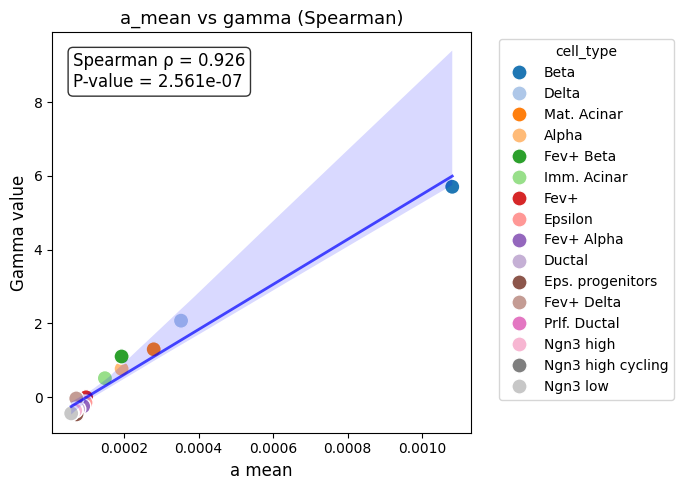

In [18]:
### We then computed the Spearman correlation between the (gamma) and the learned marginal (a) . 

spearman_r, spearman_p, fig = spearman_scatter_plot(
    a_means_df=adapt_a_means,
    gamma_df=gamma_df,
    x_col="a_means",
    y_col="gamma",
    hue_col="cell_type",
    title="a_mean vs gamma (Spearman)",
)

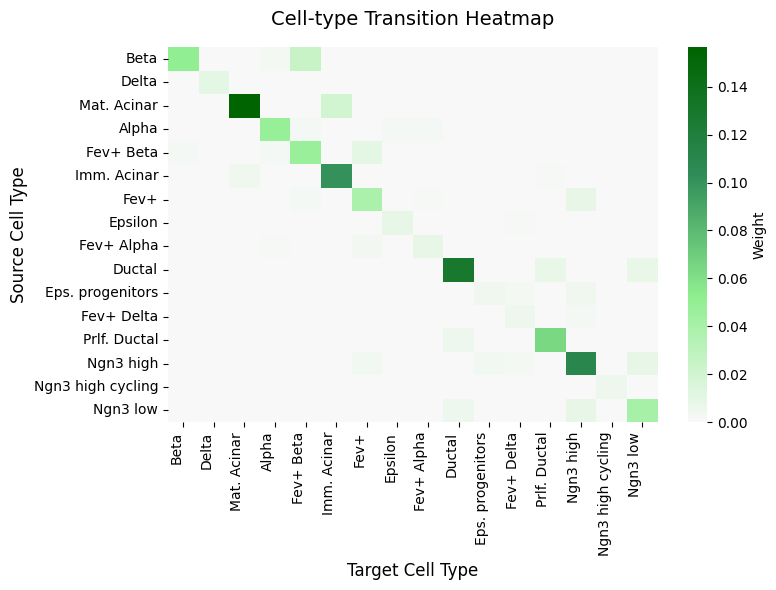

<Axes: title={'center': 'Cell-type Transition Heatmap'}, xlabel='Target Cell Type', ylabel='Source Cell Type'>

In [19]:
### The method accurately aligned cells across time points, with the cell-type alignment matrix exhibiting a clear diagonal structure.
### The horizontal axis of the heatmap represents the previous time point, while the vertical axis represents the subsequent time point.

transfer_df = aggregate_pi_by_celltype(E145, E155, pi, celltype_key="cell_type")

# The heatmap plot for cell-type alignment matrix.
plot_ALLOCATE_transfer_heatmap(
    transfer_df,
    title="Cell-type Transition Heatmap",
    savepath="adapt_pi_heatmap.pdf",
)

In [20]:
E145_155_flow_df = pi_process(E145,E155,pi, key = 'cell_type')
E145_155_flow_df

,source,target,weight
0,Mat. Acinar,Mat. Acinar,1.565037e-01
1,Ductal,Ductal,1.288562e-01
2,Ngn3 high,Ngn3 high,1.102051e-01
3,Imm. Acinar,Imm. Acinar,1.013166e-01
4,Prlf. Ductal,Prlf. Ductal,6.377559e-02
...,...,...,...
251,Imm. Acinar,Fev+,8.169368e-47
252,Delta,Prlf. Ductal,1.787318e-49
253,Prlf. Ductal,Beta,8.130775e-50
254,Imm. Acinar,Beta,5.227900e-50


In [23]:
### Finally, we calculated the cell-type mapping accuracy across two developmental stage pairs.
compute_mapping_accuracy(E145_155_flow_df,source_col= "source",target_col= "target",weight_col= "weight")

0.8310570082744301

### This is the ALLOCATE tutorial for spatial sliced data.

/lustre/home/acct-clswt/clswt-jiaxinchen/miniconda3/envs/STAligner/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


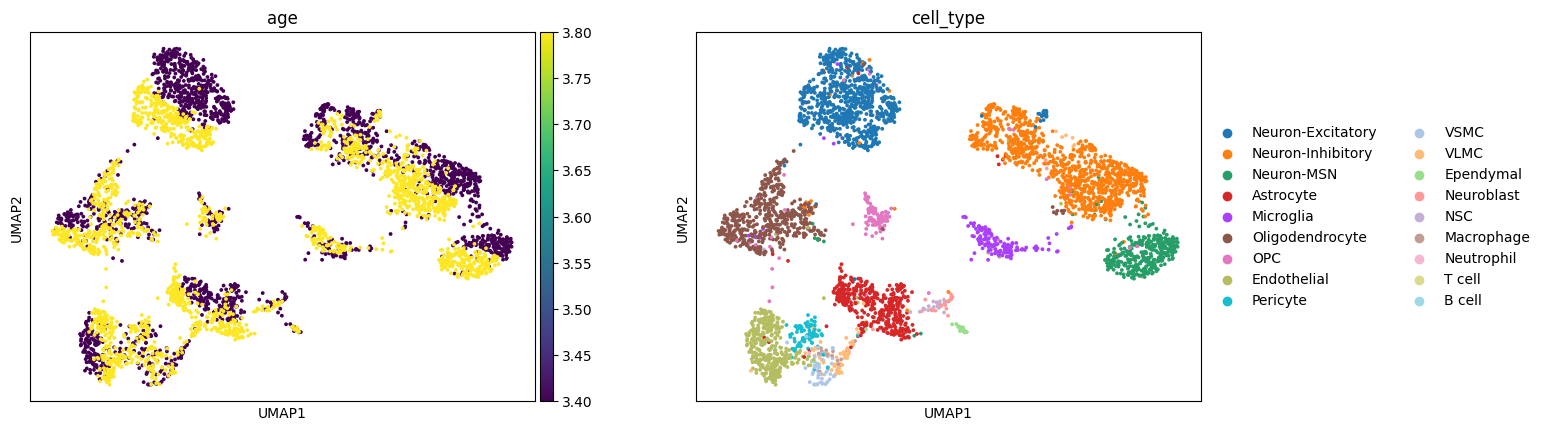

In [3]:
###### We defined a hierarchical sampling function to ensure that the proportions accurately sample a portion of the data for testing.
def stratified_subsample(adata, n_total, random_state=42):
    if n_total >= adata.n_obs:
        return adata.copy()
    indices = np.arange(adata.n_obs)
    train_idx, _ = train_test_split(
        indices, 
        train_size=n_total,
        stratify=adata.obs['cell_type'],
        random_state=random_state
    )
    return adata[train_idx].copy()

adata = sc.read("aging_coronal.h5ad")
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
unique_times = np.sort(adata.obs["age"].unique())

time1 = unique_times[0]
time2 = unique_times[1] 
mask1 = adata.obs['age'].isin([time1])  
mask2 = adata.obs['age'].isin([time2])  

slice_t1 = adata[mask1]  
slice_t2 = adata[mask2]  

# Randomly select 2,000 cells
slice_t1 = stratified_subsample(slice_t1, n_total=2000, random_state=42)
slice_t2 = stratified_subsample(slice_t2, n_total=2000, random_state=42)

import anndata as ad
joint_adata = ad.concat([slice_t1, slice_t2])
sc.pp.normalize_total(joint_adata, inplace=True)
sc.pp.log1p(joint_adata)
sc.pp.pca(joint_adata, 30)
sc.pp.neighbors(joint_adata, n_pcs=30, n_neighbors=20, use_rep='X_pca')
sc.pl.umap(joint_adata, color=['age', 'cell_type'], wspace=0.2)

### Compute the cost matrix and solve the problem.

In [4]:
from scipy.spatial import distance

joint_datamatrix = joint_adata.obsm['X_pca']

X = joint_datamatrix[:slice_t1.shape[0], :]
Y = joint_datamatrix[slice_t1.shape[0]:, :]

# Calculate expression distance
C = distance.cdist(X, Y)

C1 = distance.cdist(X, X)
C2 = distance.cdist(Y, Y)

# Calculate spatial distances
D1 = distance.cdist(slice_t1.obsm['spatial'], slice_t1.obsm['spatial'])
D2 = distance.cdist(slice_t2.obsm['spatial'], slice_t2.obsm['spatial'])

N1, N2 = C.shape[0], C.shape[1]  # 正确获取维度

# Calculate the joint cost matrix 
M1 = D1 * C1
M2 = D2 * C2

In [7]:
# Run stALLOCATE
####The main returned value (a) represents the cell growth potential and (pi) represents the cell transition matrix.
a, pi, stats, a_history = stALLOCATE(
    C,
    M1,
    M2,
    alpha=0.1,
    epsilon=0.1,
    lambda_val=0.5,
    beta=0.9,
    max_outer=40,
    max_middle=100,
    max_inner=1000,
    tol=1e-4,
    sinkhorn_tol=1e-4,
)


[scALLOCATE_fusedGW] Running fused GW-OT with alpha=0.1, beta=0.9, epsilon=0.1, lambda=0.5
5.5395753338176785 11.482692136708039
10.888226398184074
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
中间层迭代 24/100
外层迭代 1/40
5.077825295363729 11.482692136708039
10.843467897140801
0
1
2
3
4
中间层迭代 5/100
外层迭代 2/40
5.120355657091232 11.482692136708039
10.848535947683052
0
1
2
3
中间层迭代 4/100
外层迭代 3/40
5.123398302092482 11.482692136708039
10.84884715168329
0
1
中间层迭代 2/100
外层迭代 4/40
5.124394866321919 11.482692136708039
10.848956240821597
0
1
中间层迭代 2/100
外层迭代 5/40
5.1250504761974796 11.482692136708039
10.84902638279982
0
1
中间层迭代 2/100
外层迭代 6/40
5.125456305305412 11.482692136708039
10.849069663196357
0
1
中间层迭代 2/100
外层迭代 7/40
5.125713534812177 11.482692136708039
10.849097028396589
0
1
中间层迭代 2/100
[scALLOCATE_fusedGW] Done. outer_iters=8, pi_norm=0.0178


<Axes: title={'center': 'Marginal Distribution'}, xlabel='log10(a)', ylabel='Cell count'>

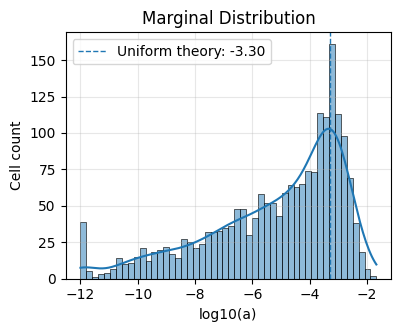

In [8]:
### ALLOCATE calculates the left marginal, and we visualize its distribution.

plot_ALLOCATE_a_distribution(
    a,
    title="Marginal Distribution",
    savepath=None,
)

/tmp/ipykernel_3971117/3310039270.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  slice_t1.obs['a_type_mean'] = slice_t1.obs.groupby('cell_type')['ot_a'].transform('mean')


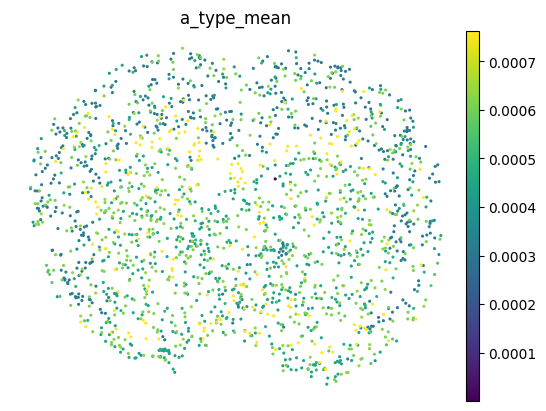

In [9]:
slice_t1.obs['ot_a'] = a

slice_t1.obs['a_type_mean'] = slice_t1.obs.groupby('cell_type')['ot_a'].transform('mean')

### ALLOCATE calculates the left marginal, and we visualize its distribution in the spatial coordinates.
sc.pl.embedding(
    slice_t1,
    basis='spatial',  # 确保adata.obsm中有'spatial'坐标
    color="a_type_mean",
    frameon=False,
    size=20,  # 统一大小
    legend_fontsize=15
)

/lustre/home/acct-clswt/clswt-jiaxinchen/data/OT_manuscript_prepare/my_allocate/src/ALLOCATE/plotting.py:373: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = adata.obs.groupby(group_key)[a_key].mean().sort_values(ascending=not descending).index.tolist()


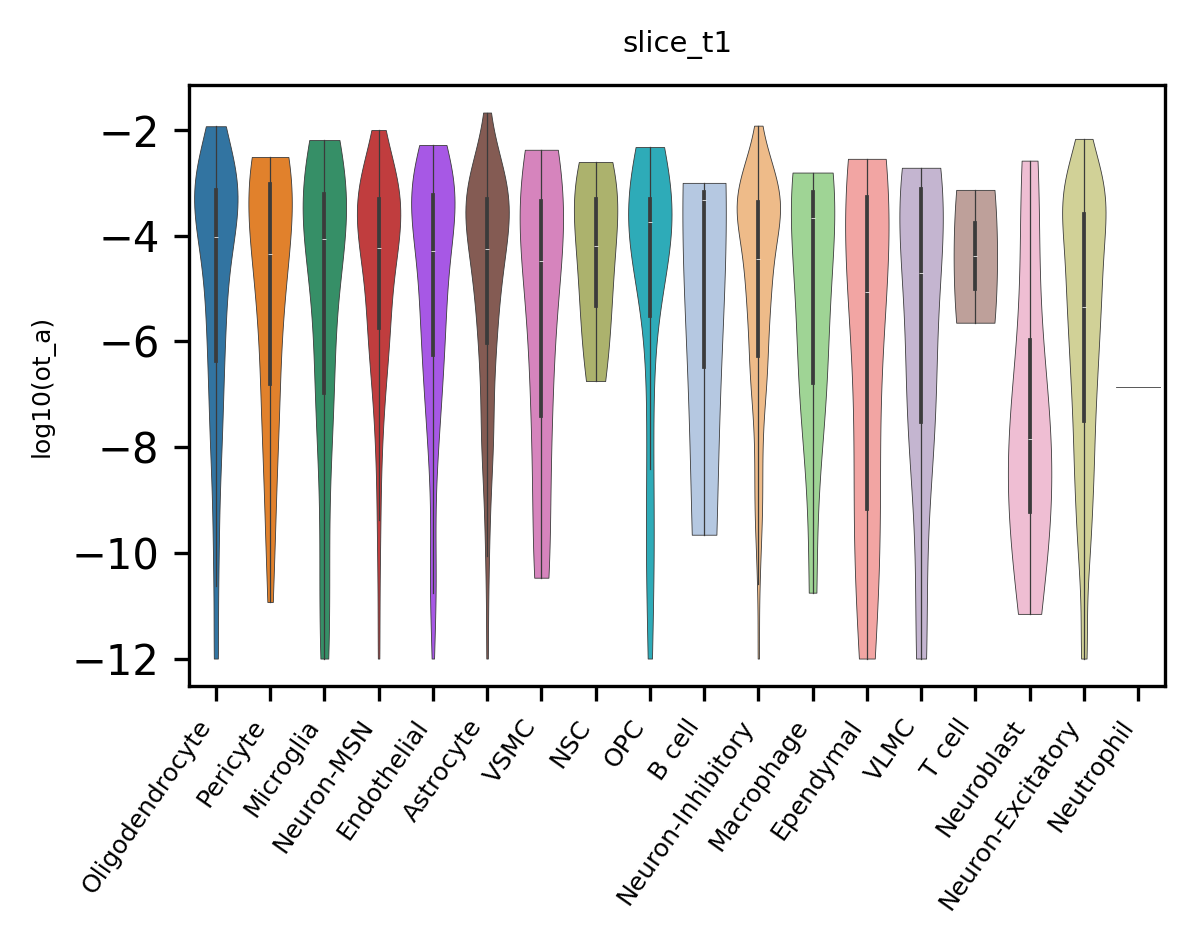

<Axes: title={'center': 'slice_t1'}, ylabel='log10(ot_a)'>

In [10]:
# We display the growth potential at slice1 for individual cells and compare it across cell types.

plot_ALLOCATE_a_violin(
    slice_t1,
    a=a,
    group_key="cell_type",
    title="slice_t1",
    savepath=None,
)

In [11]:
adapt_a = slice_t1.obs['ot_a']
adapt_a_means = adapt_a.groupby(slice_t1.obs['cell_type']).mean().reset_index(name='a_means')

pi_matrix = pi
t1 = slice_t1
t2 = slice_t2
celltype='cell_type'

###  we defined and calculated the change in cell abundance between two time points using a proliferation gamma paramater, which quantifies the relative proliferation rate between two biological conditions. 

parent_mapping, type_transfer = get_mapping(pi_matrix, t1, t2, celltype_col="cell_type")
gamma_df = compute_temporal_growth(
    early_obs=t1.obs,
    late_obs=t2.obs,
    celltype_col="cell_type",
    subtype_parent_map=parent_mapping,
)
gamma_df

/tmp/ipykernel_3971117/3172578438.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adapt_a_means = adapt_a.groupby(slice_t1.obs['cell_type']).mean().reset_index(name='a_means')


,cell_type,gamma
0,Endothelial,0.248366
1,Neuron-Excitatory,-0.371134
2,Oligodendrocyte,0.492754
3,Neuron-Inhibitory,-0.102041
4,VSMC,-0.250000
5,Microglia,0.220588
6,Astrocyte,0.174863
7,Neuron-MSN,0.120000
8,OPC,0.240000
9,Neuroblast,-0.285714


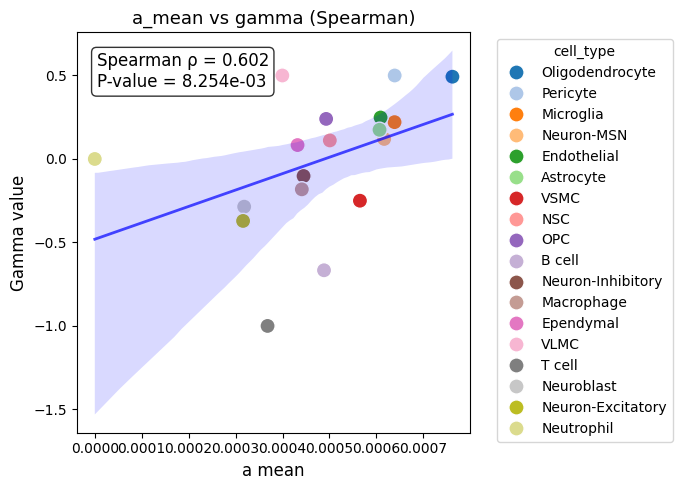

In [12]:
### We then computed the Spearman correlation between the gamma and the learned marginal a. 

spearman_r, spearman_p, fig = spearman_scatter_plot(
    a_means_df=adapt_a_means,
    gamma_df=gamma_df,
    x_col="a_means",
    y_col="gamma",
    hue_col="cell_type",
    title="a_mean vs gamma (Spearman)",
)

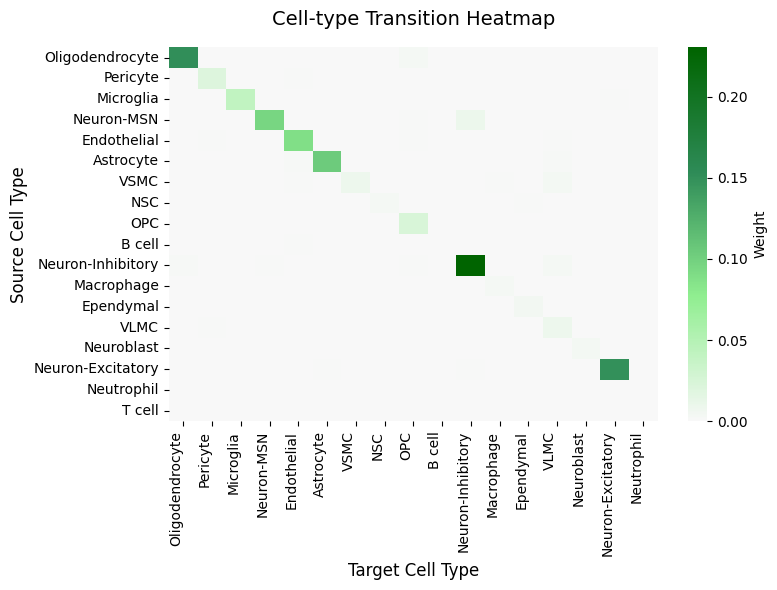

<Axes: title={'center': 'Cell-type Transition Heatmap'}, xlabel='Target Cell Type', ylabel='Source Cell Type'>

In [13]:
### The method accurately aligned cells across time points, with the cell-type alignment matrix exhibiting a clear diagonal structure.
### The horizontal axis of the heatmap represents the previous time point, while the vertical axis represents the subsequent time point.

transfer_df = aggregate_pi_by_celltype(slice_t1, slice_t2, pi, celltype_key="cell_type")

plot_ALLOCATE_transfer_heatmap(
    transfer_df,
    title="Cell-type Transition Heatmap",
    savepath="adapt_pi_heatmap.pdf",
)

In [14]:
flow_df = pi_process(slice_t1,slice_t2,pi, key = 'cell_type')
flow_df

,source,target,weight
0,Neuron-Inhibitory,Neuron-Inhibitory,2.305765e-01
1,Oligodendrocyte,Oligodendrocyte,1.512970e-01
2,Neuron-Excitatory,Neuron-Excitatory,1.499614e-01
3,Astrocyte,Astrocyte,1.039997e-01
4,Neuron-MSN,Neuron-MSN,9.593916e-02
...,...,...,...
301,Neutrophil,Astrocyte,3.377342e-32
302,Neutrophil,Neuron-Inhibitory,1.563905e-33
303,Neutrophil,Neuron-Excitatory,1.055864e-34
304,Neutrophil,Ependymal,5.591523e-36


In [15]:
### Finally, we calculated the cell-type mapping accuracy across two developmental stage pairs.

compute_mapping_accuracy(flow_df,source_col= "source",target_col= "target",weight_col= "weight")

0.936897341273208